In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from colour import delta_E
from IPython.display import clear_output

%matplotlib inline

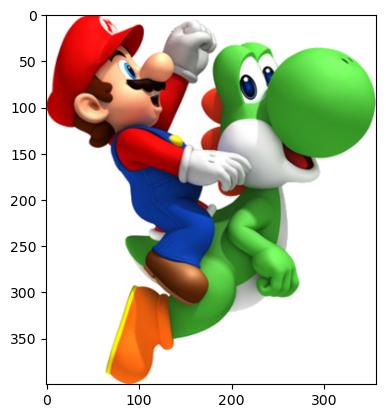

In [2]:
img = cv2.imread('mario.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.array(img, dtype=np.float32) / 255
plt.imshow(img)

In [3]:
img.shape

(400, 357, 3)

In [15]:
def initial_population(img_size, population_size):
    pop = np.zeros((population_size, *img_size), dtype=np.float32)
    for sample in pop:
        background_color = np.random.random(3)
        sample[:, :] = background_color
        for _ in range(np.random.randint(100, 200)):
            block_width = np.random.randint(0.01*img_size[0], 0.1*img_size[0])
            start_width = np.random.randint(img_size[0])
            end_width = start_width
            if start_width + block_width >= img_size[0]:
                end_width -= block_width
            elif start_width - block_width < 0:
                end_width += block_width
            else:
                end_width += np.random.choice([-1, 1])*block_width
            if start_width > end_width:
                start_width, end_width = end_width, start_width
                
            block_height = np.random.randint(0.01*img_size[1], 0.1*img_size[1])
            start_height = np.random.randint(img_size[1])
            end_height = start_height
            if start_height + block_height >= img_size[1]:
                end_height -= block_height
            elif start_height - block_height < 0:
                end_height += block_height
            else:
                end_height += np.random.choice([-1, 1])*block_height
            if start_height > end_height:
                start_height, end_height = end_height, start_height
            
            random_color = np.random.random(3)
            sample[start_width:end_width, start_height:end_height] = random_color
        
    return pop

In [5]:
def fitness(img1, img2):
    img1_lab = cv2.cvtColor(img1, cv2.COLOR_RGB2Lab)
    img2_lab = cv2.cvtColor(img2, cv2.COLOR_RGB2Lab)
    delta_e = delta_E(img1_lab, img2_lab)
    delta_e = np.mean(delta_e)
    
    return delta_e

In [6]:
def selection(gt, population, tournament_size, best_size):
    population_size = population.shape[0]
    best_size = int(population_size*best_size)
    tournament_size = int(population_size*tournament_size)
    
    best = np.zeros((best_size, *population.shape[1:]))
    for i in range(best_size):
        cands = np.random.choice(range(population_size), tournament_size)
        cands = population[cands]
        best_cand, best_fit = cands[0], fitness(gt, cands[0])
        for cand in cands[1:]:
            fit = fitness(gt, cand)
            if fit < best_fit:
                best_fit = fit
                best_cand = cand
                
        best[i] = best_cand
    
    return best

In [7]:
def crossover1(p1, p2):
    x = np.random.random()
    return x*p1 + (1-x)*p2

In [14]:
def crossover2(p1, p2):
    img_size = p1.shape
    point1 = np.random.choice(range(img_size[0]))
    point2 = np.random.choice(range(img_size[1]))
    child = np.zeros(img_size, dtype=np.float32)
    child[:point1, :point2] = p1[:point1, :point2]
    child[:point1, point2:] = p2[:point1, point2:]
    child[point1:, :point2] = p2[point1:, :point2]
    child[point1:, point2:] = p1[point1:, point2:]
    
    return child

In [9]:
def mutation(img, rate, max_blocks):
    img_size = img.shape
    new_img = img.copy()
    
    num_blocks = range(max_blocks+1)
    p = [rate**i for i in range(1, max_blocks+1)]
    p.insert(0, 1-rate)
    p /= np.sum(p)
    num = np.random.choice(num_blocks, size=1, p=p)
    
    for _ in range(num.squeeze()):
        block_width = np.random.randint(0.01*img_size[0], 0.1*img_size[0])
        start_width = np.random.randint(img_size[0])
        end_width = start_width
        if start_width + block_width >= img_size[0]:
            end_width -= block_width
        elif start_width - block_width < 0:
            end_width += block_width
        else:
            end_width += np.random.choice([-1, 1])*block_width
        if start_width > end_width:
            start_width, end_width = end_width, start_width

        block_height = np.random.randint(0.01*img_size[1], 0.1*img_size[1])
        start_height = np.random.randint(img_size[1])
        end_height = start_height
        if start_height + block_height >= img_size[1]:
            end_height -= block_height
        elif start_height - block_height < 0:
            end_height += block_height
        else:
            end_height += np.random.choice([-1, 1])*block_height
        if start_height > end_height:
            start_height, end_height = end_height, start_height

        random_color = np.random.random(3)
        new_img[start_width:end_width, start_height:end_height] = random_color
        
    return new_img

# Start

In [21]:
pop = initial_population(img.shape, 100)

In [ ]:
for i in range(100):
    best = selection(img, pop, 0.08, 0.2)
    parent_size = int(best.shape[0]*((1-0.2)/0.2))
    p1 = np.random.permutation(parent_size) % best.shape[0]
    p2 = np.random.permutation(parent_size) % best.shape[0]
    for j in range(p1.shape[0]):
        if np.random.random() <= 0.7:
            pop[j] = crossover1(best[p1[j]], best[p2[j]])
        else:
            pop[j] = crossover2(best[p1[j]], best[p2[j]])
        pop[j] = mutation(pop[j], 0.3, 3)
    pop[p1.shape[0]:] = best
    
    clear_output(wait=True)
    print(i)

9


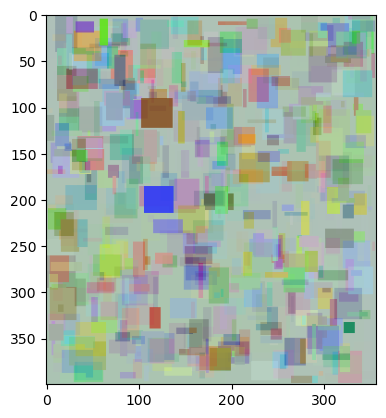

In [20]:
plt.imshow(pop[1])